# Classification

The aim of this is to use the normalised college data to train a model that predicts the likelihood of college acceptance, given several factors. Some factors have to do with the student (e.g. GPA, minority), and some have to do with the college (e.g. acceptance rate, private/public). Together, these predictors should fit a model that returns probability of being accepted by a college. 

Load required packages. 

In [1]:
import TIdatabase as ti
%matplotlib inline 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from matplotlib import rcParams
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn import svm
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

### Data Cleaning & Checking

We read in the normalized data. 

In [2]:
df = pd.read_csv("collegedata_normalized.csv", index_col=0)
df.head()

,studentID,classrank,admissionstest,AP,averageAP,SATsubject,GPA,GPA_w,program,schooltype,...,alumni,outofstate,acceptStatus,acceptProb,name,acceptrate,size,public,finAidPct,instatePct
0,S50C3UECT8,NaN,0.838909,7,1.067927,3,-0.188104,0.059072,Biomedical engineering,0,...,0,0,1,NaN,Rice,0.151,6621,0,0,0
1,GBWZQQRBEV,NaN,0.666993,7,0.661638,2,0.493061,0.398012,Classics,0,...,0,1,1,NaN,Rice,0.151,6621,0,0,0
2,MXXLWO1HQ2,NaN,0.208552,0,NaN,3,0.395752,-1.035963,Biological Science,1,...,0,1,0,NaN,Rice,0.151,6621,0,0,0
3,5KSL7C8SLZ,NaN,1.297350,7,0.864783,4,0.103824,-0.384156,Physics,1,...,0,1,0,NaN,Rice,0.151,6621,0,0,0
4,RQWLNGGZ49,NaN,0.323162,1,-0.354087,2,0.541716,NaN,NaN,1,...,0,1,1,NaN,Rice,0.151,6621,0,0,0


Then we check how much of the data is missing. The cell below shows that 23% of all entries are null. This is way too high. 

In [3]:
x = df.isnull().sum(axis=1).tolist()
y = float(sum(x)) / (df.shape[0]*df.shape[1])
print 'Fraction nulls = ', y

Fraction nulls =  0.232593074511


To decrease the proportion of NaNs, we get rid of columns which are almost all null. From the `df.head()` above, it appears like some columns have almost exclusively nulls. Therefore the 23% above is probably driven mainly by columns that are basically all null. To see this, we print and plot the % null values for each column. We see the histogram is very bimodal. 

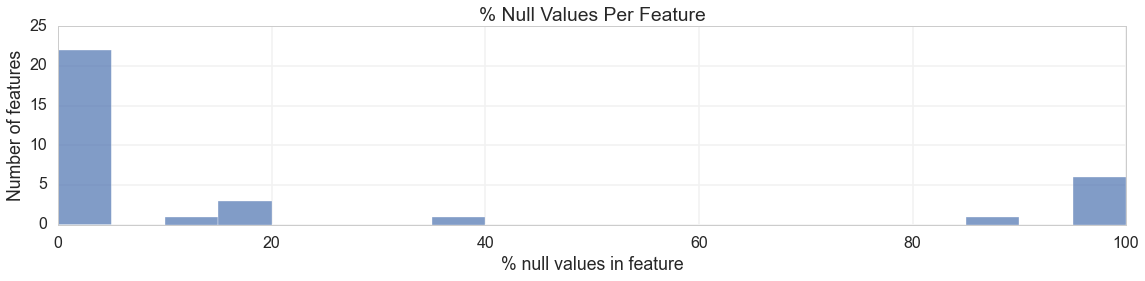

In [4]:
percentnulls = {}
for i in range(len(df.columns)):
    percentnulls[df.columns[i]] = 100.0 * df[df.columns[i]].isnull().sum() / len(df[df.columns[i]])
    
# plt.barh(range(len(df.columns)),percentnulls.values(), align="center")
# plt.ylim([0,20])
# plt.yticks(range(len(df.columns)), percentnulls.keys())
# plt.ylabel("feature")
# plt.xlabel("% nulls")
# plt.title("% Nulls Per Feature")
# plt.show()

# plt.scatter(range(len(df.columns)),percentnulls.values(),s=100)
# plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
# plt.ylabel("% null values")
# plt.title("Proportion of Null Values By Feature")
# plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (16,4))
plt.hist(percentnulls.values(),bins=20,alpha=0.7,edgecolor="white")
plt.xlabel("% null values in feature")
plt.ylabel("Number of features")
plt.title("% Null Values Per Feature")
plt.gca().xaxis.grid(True,color='0.95')
plt.gca().yaxis.grid(True,color='0.95')
plt.tight_layout()
plt.show()

In [5]:
[i for i in percentnulls.keys() if percentnulls[i] > 20 and percentnulls[i] < 80]

['addInfo']

The histogram shows us that (apart from the `addInfo` feature), if a feature has >50% missing values, it has >80% null values, and if there are $<50%$ nulls, there are < 20% null values. This means if we remove columns with >50% missing data, we will be removing most of the nulls in the data frame, and it won't actually remove much information. As for the `addInfo` feature, this is additional information about the candidate, and at this stage we are not using it in the model. 

We thus remove any column that has 50% or more null values. This takes out any predictors that would have been useless anyway. 

In [6]:
cols_to_drop = []
for i in df.columns:
    if 1.0* df[i].isnull().sum() / len(df[i]) >= 0.5:
        cols_to_drop.append(i)
print "Columns to drop: ", cols_to_drop
dfr = df.drop(cols_to_drop,axis=1)

Columns to drop:  ['classrank', 'canAfford', 'firstinfamily', 'artist', 'workexp', 'visited', 'acceptProb']


We also drop all columns where the accept status is NaN. These are of course useless as well.

In [7]:
dfr = dfr[pd.notnull(df["acceptStatus"])]

In [8]:
x = dfr.isnull().sum(axis=1).tolist()
y = float(sum(x)) / (dfr.shape[0]*dfr.shape[1])
print 'Fraction nulls = ', y

Fraction nulls =  0.0315301778112


Now we have only 3% null values. Good! The next step is to choose which columns we want to use to predict. Obviously columns like `studentID`, while crucial, are not actually predictors. Also, we remove weighted GPA in favour of GPA, as we have already normalised everything. We also do not include finAidpct and instatepct, as these columns are all 0. 

In [9]:
print dfr.columns
predictor_cols = ["admissionstest","AP","averageAP","SATsubject","GPA","schooltype","intendedgradyear","female","MinorityRace","international","sports","earlyAppl","alumni","outofstate","acceptrate","size","public"]
dfpredict = dfr[predictor_cols]
dfresponse = dfr["acceptStatus"]

Index([u'studentID', u'admissionstest', u'AP', u'averageAP', u'SATsubject',
       u'GPA', u'GPA_w', u'program', u'schooltype', u'intendedgradyear',
       u'addInfo', u'female', u'MinorityGender', u'MinorityRace',
       u'international', u'sports', u'collegeID', u'earlyAppl', u'alumni',
       u'outofstate', u'acceptStatus', u'name', u'acceptrate', u'size',
       u'public', u'finAidPct', u'instatePct'],
      dtype='object')


In [10]:
dfpredict.columns

Index([u'admissionstest', u'AP', u'averageAP', u'SATsubject', u'GPA',
       u'schooltype', u'intendedgradyear', u'female', u'MinorityRace',
       u'international', u'sports', u'earlyAppl', u'alumni', u'outofstate',
       u'acceptrate', u'size', u'public'],
      dtype='object')

The code below demonstrates that if we remove all the rows with ANY nulls in it, we reduce our dataset from 13k to 11k. This reduces our dataset too much. So we will impute the missing values. We initially tried to do this using the `mice` package in R, but there does not seem to be an equivalent in Python. Since the % of nulls is just 4%, it shouldn't matter too much what method we use. Since some of the variables are factor, not numerical, we can't use mean or media. We are looking into KNN imputation, but for the time being, just use median. As stated, it shouldn't matter too much what method we use. 

In [11]:
print dfpredict.dropna(axis=0,how="any").shape
print dfpredict.shape

(10917, 17)
(13310, 17)


In [12]:
imp = Imputer(missing_values="NaN", strategy="median", axis=1)
imp.fit(dfpredict)
X = imp.transform(dfpredict)
y = dfresponse
X.shape, y.shape

((13310, 17), (13310,))

Next, we create a training and test data set. The training data will be used to fit the model and the test data to test the model accuracy. 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape
#X_train, X_validate, y_train, y_validate = train_test_split(X1, y1, test_size=0.25)
#print X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

(10648, 17) (2662, 17) (10648,) (2662,)


### Baselines
Let's start with evaluating our starting point. What accuracy do we get with the uttermost simple classifier: predicting that all students get accepted (or all students get rejected). Whichever of these is the highest, will be our accuracy to beat. 

In [14]:
# predict all accepted
print 'Accuracy when predicting all accepted = ', metrics.accuracy_score(y_test, np.ones(y_test.shape))
# predict all rejected
print 'Accuracy when predicting all rejected = ', metrics.accuracy_score(y_test,np.zeros(y_test.shape))

Accuracy when predicting all accepted =  0.368895567243
Accuracy when predicting all rejected =  0.631104432757


Our baseline is thus an accuracy of 60%, when we predict that no one gets accepted to their universities.  

### Logistic Regression

We start with a logistic regression. We use cross validation to choose the hyperparameter c. The score for each c is the mean of the scores from the cross validation folds and is stored in a dictionary. 

In [15]:
cdict = {}
for c in [0.001,0.01,0.1,1,10,100,1000]:
    clf = linear_model.LogisticRegression(C=c)
    #clf.fit(X_train,y_train)
    #predicted = clf.predict(X_validate)
    #cdict[c] = metrics.accuracy_score(y_validate, predicted)
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    cdict[c] = scores.mean()

We pick the c value with highest accuracy and fit the model using this value. 

In [16]:
print cdict
best_c = max(cdict, key=cdict.get)
print 'Best parameter: ', best_c, cdict[best_c]
clflog = linear_model.LogisticRegression(C=best_c)
clflog.fit(X_train,y_train)
predicted = clflog.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test, predicted) 

{1: 0.66172349607201608, 100: 0.66191133360291621, 0.1: 0.66153565854111596, 1000: 0.66191133360291621, 10: 0.66191133360291621, 0.001: 0.65909302079423782, 0.01: 0.66266294838992967}
Best parameter:  0.01 0.66266294839
Accuracy on test set:  0.664537941397


We got ~65% accuracy. Not bad, but different models may be able to do better. 

### Random Forest

Now we try a random forest, and follow the same procedure as before to choose the number of trees.

In [17]:
ntdict = {}
for nt in [100,250,500,1000,2500]:
    clf = RandomForestClassifier(n_estimators=nt,criterion="gini")
    #clf.fit(X_train,y_train)
    #predicted = clf.predict(X_validate)
    #ntdict[nt] = metrics.accuracy_score(y_validate, predicted)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    ntdict[nt] = scores.mean()

In [18]:
print ntdict
best_nt = max(ntdict, key=ntdict.get)
print 'Best parameter: ',best_nt, ntdict[best_nt]
clfRF_gini = RandomForestClassifier(n_estimators=nt)
clfRF_gini.fit(X_train,y_train)
predicted = clfRF_gini.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)

{1000: 0.74370636195761797, 500: 0.74323723088776394, 250: 0.74511485693108315, 100: 0.7436136998570182, 2500: 0.74276752704969307}
Best parameter:  250 0.745114856931
Accuracy on test set:  0.753193087904


We repeat the random forst, but now using `entropy` instead of `gini`.

In [ ]:
ntdict = {}
# We added 5000 because a few times, the optimal number of trees was on the edge
for nt in [250,500,1000,2500,5000]:
    clf = RandomForestClassifier(n_estimators=nt,criterion="entropy")
    #clf.fit(X_train,y_train)
    #predicted = clf.predict(X_validate)
    #ntdict[nt] = metrics.accuracy_score(y_validate, predicted)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    ntdict[nt] = scores.mean()
print ntdict
best_nt = max(ntdict, key=ntdict.get)
print 'Best parameter: ',best_nt, ntdict[best_nt]
clfRF_ent = RandomForestClassifier(n_estimators=nt)
clfRF_ent.fit(X_train,y_train)
predicted = clfRF_ent.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)

It appears `entropy` is pretty much the same as `gini`. This model gets about 73% accuracy, so is clearly better than logistic regression. 
Let's take a look at feature importance. 

In [26]:
# create interpretable labels for the columns
better_labels = {
    "admissionstest": "ACT/SAT score",
    "acceptrate": "College acceptance rate",
    "GPA": "GPA",
    "averageAP": "Average AP score",
    "intendedgradyear": "College graduation year",
    "size": "College size",
    "AP": "# AP exams taken",
    "SATsubject": "# SAT subject tests taken",
    "female": "Gender / Female",
    "schooltype": "Private High School",
    "MinorityRace": "Underrepresented Minority",
    "earlyAppl": "Early Application",
    "outofstate": "Out of State",
    "public": "Public College",
    "alumni": "Legacy",
    "international": "International Student",
    "sports": "Varsity Sports"
    }

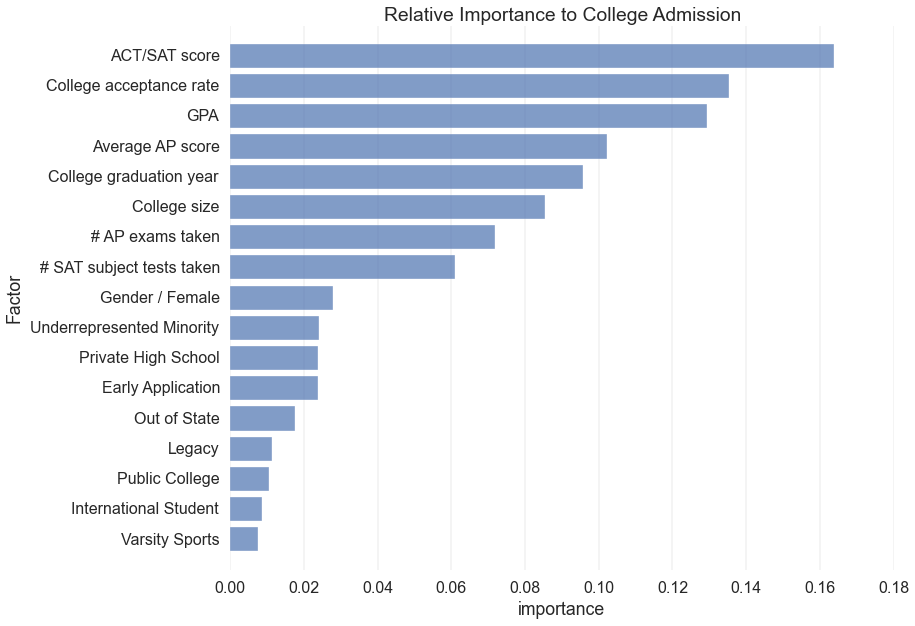

In [27]:
# create dictionary of feature importances
clf=clfRF_gini
feature_importance = {}
for i in range(len(dfpredict.columns)):
    feature_importance[better_labels[dfpredict.columns[i]]] = clf.feature_importances_[i]
# plot sorted importances
sns.set_style("white")
plt.barh(range(len(dfpredict.columns)),sorted(feature_importance.values()), align="center",alpha=0.7,edgecolor='white')
plt.ylim([-1,17])
plt.yticks(range(len(dfpredict.columns)), sorted(feature_importance,key=feature_importance.get))
plt.ylabel("Factor")
plt.xlabel("importance")
plt.title("Relative Importance to College Admission")
plt.gca().yaxis.grid(False)
plt.gca().xaxis.grid(True,color='0.95')
plt.tight_layout()
sns.despine(left=True,bottom=True)
plt.savefig("features.png")
plt.show()


The above plot shows that the admission test scores, the school's acceptance rate and the GPA score are the most important factors in the decision. This is as we expected and what most people think. 

### Decision Tree

Below is a decision tree classifier. Its performance will probably be worse than that of the random forest, as it is in some sense just a subset of a random forest. 

In [49]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
predicted = dt.predict(X_test)
print 'Accuracy on test test:', metrics.accuracy_score(y_test, predicted)

Accuracy on test test: 0.679188580015


This one got us only 68% accuracy, so again significantly worse than the random forest. So at this stage, random forest is still the best!

### K Nearest Neighbours
Now, let's see how a K-nearest neighbour classifier does.

In [50]:
kdict = {}
for k in [10,15,20,25,30,35]:
    clf = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    kdict[k] = scores.mean()
print kdict
best_k = max(kdict, key=kdict.get)
print 'Best parameter: ',best_k, kdict[best_k]
clfknn = KNeighborsClassifier(n_neighbors=best_k)
clfknn.fit(X_train,y_train)
predicted = clfknn.predict(X_test)
print 'Accuracy on test set: ', metrics.accuracy_score(y_test,predicted)

{35: 0.69139344840975669, 10: 0.68820184263475592, 15: 0.69054943697271354, 20: 0.69298969254121212, 25: 0.69336607363479119, 30: 0.69374166048925123}
Best parameter:  30 0.693741660489
Accuracy on test set:  0.706611570248


This method performs second best to our random forest. 

### SVM

Finally, we try a Linear SVM. 

In [51]:
cdict = {}
for c in [0.0001,0.001,0.01,0.1,1,10]:
    clf = svm.LinearSVC(loss="hinge",C=c);
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cdict[c] = scores.mean()
print cdict
best_c = max(cdict, key=cdict.get)
print 'Best parameter: ', best_c, cdict[best_c]
clf = svm.LinearSVC(loss="hinge",C=best_c);
clf.fit(X_train,y_train)
predicted = clf.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)

{1: 0.47791291609304959, 0.1: 0.52795871721557419, 10: 0.57603780578206076, 0.001: 0.57316804334780613, 0.0001: 0.58030419358254792, 0.01: 0.61974081330085773}
Best parameter:  0.01 0.619740813301
Accuracy on test set:  0.617956423742


This one is our worst predictor, giving only 61% accuracy. This is barely better than the baseline, but this is maybe not surprising. We should try a kernelized SVM. 

In [52]:
cdict = {}
for c in [0.001,0.01,0.1,1,10,100,1000]:
    clf = svm.SVC(C=c);
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cdict[c] = scores.mean()
print cdict
best_c = max(cdict, key=cdict.get)
print 'Best parameter: ',best_c, cdict[best_c]
clfsvm = svm.SVC(C=best_c);
clfsvm.fit(X_train,y_train)
predicted = clfsvm.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)

{1: 0.70764110981679551, 100: 0.65364291009213171, 0.1: 0.68190917434431142, 1000: 0.63701939708425992, 10: 0.6914872568745809, 0.001: 0.61974081330085773, 0.01: 0.61974081330085773}
Best parameter:  1 0.707641109817
Accuracy on test set:  0.722764838467


The RBF SVM is doing very well! However, random forest is still better. 

### Adaboost

In [53]:
from sklearn.ensemble import AdaBoostClassifier
ndict={}
for n in [50,100,150,200,250]:
    clf = AdaBoostClassifier(n_estimators=n);
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    ndict[n] = scores.mean()
print ndict
best_n = max(ndict, key=ndict.get)
print 'Best parameter: ',best_n, ndict[best_n]
clfada = AdaBoostClassifier(n_estimators=best_n);
clfada.fit(X_train,y_train)
predicted = clfada.predict(X_test)
print 'Accuracy on test set: ', metrics.accuracy_score(y_test,predicted)

{200: 0.73140333227434795, 50: 0.72990054361255263, 100: 0.73008807229340955, 250: 0.73234168166896108, 150: 0.73121474460799885}
Best parameter:  250 0.732341681669
Accuracy on test set:  0.727272727273


We are getting closer to our random forest accuracy, but in the end, it looks like random forest is the one! To conclude, let's summarize our best classifiers with ROC curves.

## Summary

In [54]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.1,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

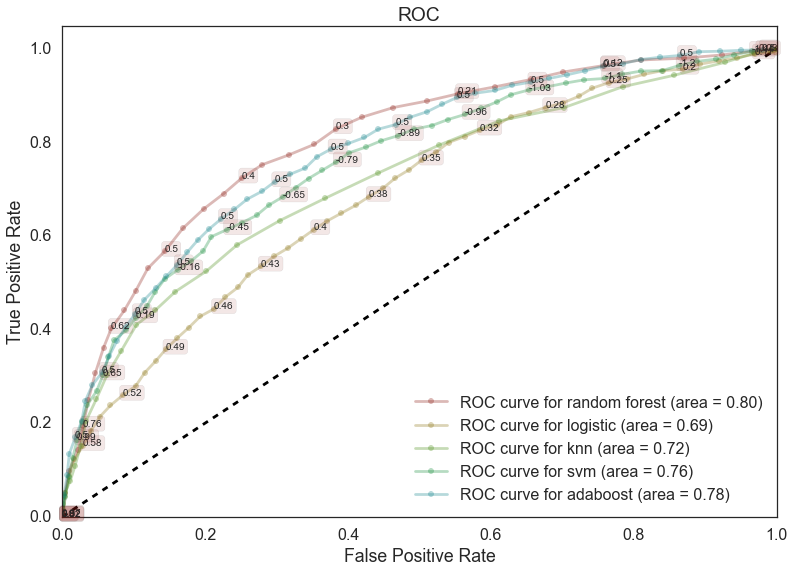

In [55]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("random forest",clfRF_gini,y_test,X_test,labe=200,skip=50,proba=True)
    make_roc("logistic",clflog, y_test, X_test, ax=ax, labe=200, skip=50,proba=True)
    make_roc("knn",clfknn,y_test,X_test,ax=ax,labe=100,proba=True)
    make_roc("svm",clfsvm,y_test,X_test,ax=ax,labe=200,skip=50,proba=False)
    make_roc("adaboost",clfada,y_test,X_test,ax=ax,labe=200,skip=50,proba=True)

The random forest classifier is the best one. Its ROC curve is always reaches a higher true postive rate and lower false positive rate. It is closely followed by the Adaboost classifier. 

In [56]:
#slope=np.float((y_test==0).sum())/(y_test==1).sum()
#slope
#x=np.arange(0.,1., 0.02)
#with sns.hls_palette(8, l=.3, s=.8):
#    intercept=0.34
#    ax = make_roc("random forest",clfRF_gini,y_test,X_test,labe=200,skip=50,proba=True)
#    make_roc("logistic",clflog, y_test, X_test, labe=200, skip=50,proba=True)
#    make_roc("knn",clfknn,y_test,X_test,ax=ax,labe=200,skip=50,proba=True)
#    make_roc("svm",clfsvm,y_test,X_test,ax=ax,labe=200,skip=50,proba=False)
#    make_roc("adaboost",clfada,y_test,X_test,ax=ax,labe=200,skip=50,proba=True)
#    ax.plot(x,intercept+slope*x,alpha=0.4,label='Tangent')
#    ax.legend(loc='lower right')
#    ax.set_xlabel('FPR')
#    ax.set_ylabel('TPR')

### Dropping `Intended Graduation Year` As A Predictor

Given that the `intendedgradyear` in our data only stretches back as far as 2009, it is worth seeing whether dropping it as a predictor will help. This assumes that the admissions regime at all of the top 25 colleges has not drastically changed over the last few years. 

The reason we are dropping this is because people who use the site will input an intended graduation year of >2019, whereas all of our data has intended graduation year of 2009-2019. Therefore using it as a feature would be extrapolation by definition, so is not entirely reliable. 

We drop the column from the training and test sets, not from the original data frame. The reason behind this is that we don't want to compare the accuracy for different training/test splits, so we need to ensure the same split is used below as was used above. 

In [32]:
index_igy = [index for index,value in enumerate(dfpredict.columns) if value == "intendedgradyear"]
select = [i for i in range(X_train.shape[1]) if i not in index_igy]

In [33]:
#dfpredict1 = dfpredict.drop("intendedgradyear",axis=1)
#X1 = imp.transform(dfpredict1)
#y1 = dfresponse
#X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2)
X_train1 = X_train[:,select]
X_test1 = X_test[:,select]
y_train1=y_train
y_test1=y_test
print 'Random Forest: '
ntdict = {}
for nt in [5,10,25,50,100,250,500,1000]:
    clf = RandomForestClassifier(n_estimators=nt,criterion="gini")
    scores = cross_val_score(clf, X_train1, y_train1, cv=5)
    ntdict[nt] = scores.mean()
print ntdict
best_nt = max(ntdict, key=ntdict.get)
print 'Best parameter: ',best_nt, ntdict[best_nt]
clfRF = RandomForestClassifier(n_estimators=nt)
clfRF.fit(X_train1,y_train1)
predicted = clfRF.predict(X_test1)
print 'Accuracy on test set: ', metrics.accuracy_score(y_test1,predicted)
print 'Adaboost: '
ndict={}
for n in [50,100,150,200,250]:
    clf = AdaBoostClassifier(n_estimators=n);
    scores = cross_val_score(clf, X_train1, y_train1, cv=5, scoring='accuracy')
    ndict[n] = scores.mean()
print ndict
best_n = max(ndict, key=ndict.get)
print 'Best parameter: ',best_n, ndict[best_n]
clfADA = AdaBoostClassifier(n_estimators=best_n);
clfADA.fit(X_train1,y_train1)
predicted = clfADA.predict(X_test1)
print 'Accuracy on test set: ', metrics.accuracy_score(y_test1,predicted)

Random Forest: 
{100: 0.73572359684403865, 5: 0.69365138139322691, 1000: 0.73403389653895945, 10: 0.71487380641817, 50: 0.72943189891817162, 500: 0.7344093952688644, 25: 0.72727152457706457, 250: 0.73356406022430864}
Best parameter:  100 0.735723596844
Accuracy on test set:  0.745679939895
Adaboost: 


NameError: name 'AdaBoostClassifier' is not defined

Our accuracy has dropped slightly, but with an acceptable amount. We are still gaining at least 10% compared to the baseline. Moreover, the little extra accuracy we obtained when including `intendedgradyear` may just be due to overfitting and thus not valid anyway when we want to predict for new users. 

### Updating the Factor Weights

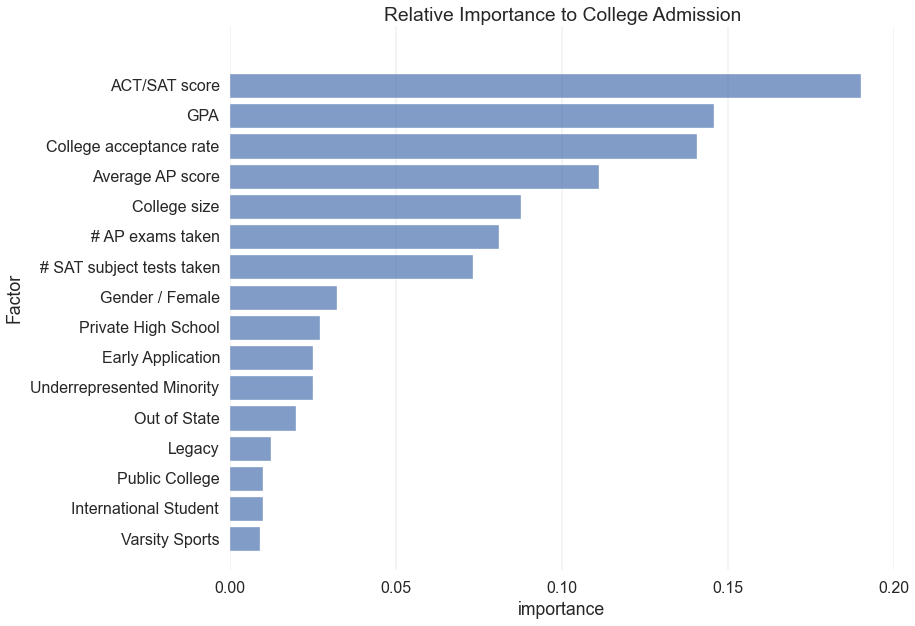

In [39]:
# create interpretable labels for the columns
better_labels = {
    "admissionstest": "ACT/SAT score",
    "acceptrate": "College acceptance rate",
    "GPA": "GPA",
    "averageAP": "Average AP score",
    "size": "College size",
    "AP": "# AP exams taken",
    "SATsubject": "# SAT subject tests taken",
    "female": "Gender / Female",
    "schooltype": "Private High School",
    "MinorityRace": "Underrepresented Minority",
    "earlyAppl": "Early Application",
    "outofstate": "Out of State",
    "public": "Public College",
    "alumni": "Legacy",
    "international": "International Student",
    "sports": "Varsity Sports"
    }
# create dictionary of feature importances
dfpredict1 = dfpredict.drop("intendedgradyear",axis=1)
X1 = imp.transform(dfpredict1)
y1 = dfresponse
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2)
clf = RandomForestClassifier(n_estimators=100,criterion="gini")
clf.fit(X_train1,y_train1)
feature_importance = {}
for i in range(len(dfpredict1.columns)):
    feature_importance[better_labels[dfpredict1.columns[i]]] = clf.feature_importances_[i]
# plot sorted importances
sns.set_style("white")
plt.barh(range(len(dfpredict1.columns)),sorted(feature_importance.values()), align="center",alpha=0.7,edgecolor='white')
plt.ylim([-1,17])
plt.yticks(range(len(dfpredict1.columns)), sorted(feature_importance,key=feature_importance.get))
plt.ylabel("Factor")
plt.xlabel("importance")
plt.title("Relative Importance to College Admission")
plt.gca().yaxis.grid(False)
plt.gca().xaxis.grid(True,color='0.95')
plt.tight_layout()
sns.despine(left=True,bottom=True)
plt.savefig("features.png")
plt.show()

## Predicting the probability of getting into college

Let's now use our best classifier to predict the probability that a new candidate gets into each of the universities. We use the classifiers' `predict_proba` function to obtain this information. It is the answer we want to give users of our web app.

In [61]:
### test a candidate's chances for each college

candidate = [0.926899206,7,1.06733864,
             3,-0.187109979,0,1,
             0,0,0,0,0,
             0]

college_cols = ["acceptrate","size","public"]
colleges = ti.College()
preds = []
for i, row in colleges.df.iterrows():
    Xp1 = candidate + list(row[college_cols])
    y_rf = clfRF.predict_proba(Xp1)[0][1]
    y_ada = clfADA.predict_proba(Xp1)[0][1]
    p =  {'college':row.collegeID, 'prob':(y_rf,y_ada)}
    preds.append(p)
    
preds   

[{'college': 'Princeton', 'prob': (0.25900000000000001, 0.4987876128471167)},
 {'college': 'Harvard', 'prob': (0.19500000000000001, 0.49857518339584883)},
 {'college': 'Yale', 'prob': (0.17899999999999999, 0.49828623134585526)},
 {'college': 'Columbia', 'prob': (0.27600000000000002, 0.49900936946180929)},
 {'college': 'Stanford', 'prob': (0.222, 0.49838209310374154)},
 {'college': 'UChicago', 'prob': (0.504, 0.49977900933022046)},
 {'college': 'MIT', 'prob': (0.24099999999999999, 0.49837262452263359)},
 {'college': 'Duke', 'prob': (0.47399999999999998, 0.49971403882959303)},
 {'college': 'UPenn', 'prob': (0.30499999999999999, 0.49931885819598687)},
 {'college': 'CalTech', 'prob': (0.44600000000000001, 0.49930008513930774)},
 {'college': 'JohnsHopkins',
  'prob': (0.53600000000000003, 0.50046444528522016)},
 {'college': 'Dartmouth', 'prob': (0.45100000000000001, 0.49950394548319976)},
 {'college': 'Northwestern',
  'prob': (0.59699999999999998, 0.50055258946718773)},
 {'college': 'Brown